In [46]:
import numpy as np
import matplotlib as plt
from matplotlib.image import imread
import matplotlib.pyplot as p
%matplotlib inline

In [47]:
np.convolve([1,2,3,4,5],[1,2])

array([ 1,  4,  7, 10, 13, 10])

In [63]:
b = imread("H_test.jpg")

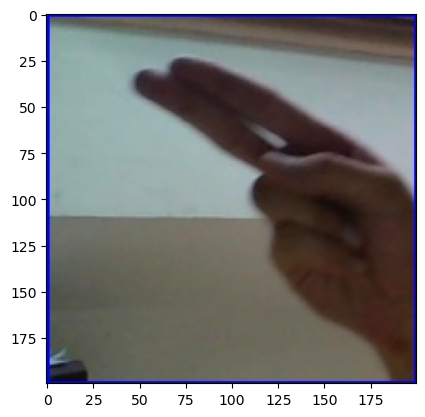

In [78]:
p.imshow(b)

In [79]:
a = np.array([[-1,1,-1], [-1,1,-1], [-1,1,-1]])

In [80]:
d = b[:, :, 0]
c = np.convolve(d, a)

ValueError: object too deep for desired array

In [82]:
b[0:200,0:200,0]

array([[ 0,  0,  0, ...,  7,  0,  0],
       [ 0,  0,  9, ..., 15,  9,  0],
       [ 7, 12, 73, ..., 58, 47, 13],
       ...,
       [ 4,  8, 15, ..., 67, 53, 21],
       [ 1,  3,  4, ..., 54, 43, 17],
       [ 0,  4, 10, ..., 20, 20, 11]], dtype=uint8)